In [1]:
!nvidia-smi

Mon Jan 22 10:00:04 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.24       Driver Version: 528.24       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
|  0%   32C    P8     9W / 320W |   1277MiB / 16376MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import sys

module_path='/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/supervised_contrastive_learning/FT-Transformer/'
if module_path not in sys.path:
    sys.path.append(module_path)
    
from data_provider import *
from pytorch_metric_learning import losses
import torch.optim as optim

c:\Users\DAHS\anaconda3\envs\DL\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
mimic_data_dir = '/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Case Labeling/MIMIC-IV.csv.gz'

## Build Dataset 
print(f'Build Dataset ....')

dataset_train = TableDataset(data_path=mimic_data_dir, data_type='mimic',mode='train',seed=393, augmentation = True)

loader_train = DataLoader(dataset_train, batch_size=128, shuffle=True, drop_last=True)

dataset_val = TableDataset(data_path=mimic_data_dir, data_type='mimic',mode='valid',seed=393, augmentation = False)
loader_val = DataLoader(dataset_val, batch_size=128, shuffle=False, drop_last=True)

Build Dataset ....
========== 데이터셋 분할 정보 ==========
데이터셋 비율: 학습 = 0.70, 테스트 = 0.30
학습셋 클래스 비율: classes
0    437041
1     41871
2     11988
3    168043
Name: count, dtype: int64
테스트셋 클래스 비율: classes
0    175017
1     17691
2      5001
3     70832
Name: count, dtype: int64
--------------------------------------
========== 클래스 비율 ==========
학습셋 클래스 비율: 0.66:0.06:0.02:0.26
테스트셋 클래스 비율: 0.65:0.07:0.02:0.26
--------------------------------------
========== 환자 및 체류 정보 ==========
학습셋 환자 수: 5982
테스트셋 환자 수: 2564
학습셋 체류 수: 6214
테스트셋 체류 수: 2669
--------------------------------------
========== 실험 설정 ==========
분할 시드: 393
학습 비율: 0.7
임계값: 0.05
--------------------------------------
========== 실행 결과 ==========
총 소요 시간(초): 0.69
시도한 시행 횟수: 0
========== 클래스 비율 ==========
학습셋 클래스 비율 classes
0    437041
1    168043
2    168043
3    168043
Name: count, dtype: int64
========== 데이터셋 분할 정보 ==========
데이터셋 비율: 학습 = 0.70, 테스트 = 0.30
학습셋 클래스 비율: classes
0    437041
1     41871
2     11988
3    168043
Name: count

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

SEED = 9861
seed_everything(seed = SEED)

In [5]:
class Contrastive_Embedding(nn.Module): #supervised contrastive learning
    def __init__(self, input_size, drop_rate, hidden_unit_sizes):
        super(Contrastive_Embedding, self).__init__()
        self.input_size = input_size
        self.hidden_unit_sizes = hidden_unit_sizes
        
        leaky_relu = nn.LeakyReLU()
        
        encoder = [nn.Linear(input_size, hidden_unit_sizes[0]),
                   nn.BatchNorm1d(hidden_unit_sizes[0]),
                   nn.Dropout(drop_rate),
                   leaky_relu]
    
        
        for i in range(1,len(hidden_unit_sizes)):
        
                encoder.append(nn.Linear(hidden_unit_sizes[i-1], hidden_unit_sizes[i]))
                encoder.append(nn.BatchNorm1d(hidden_unit_sizes[i]))
                encoder.append(nn.Dropout(drop_rate))
                encoder.append(leaky_relu)
                
        self.encoder = nn.Sequential(
            *encoder
        )
        

    def forward(self, x_cat, x_num):
        xs = []
        xs.append(x_cat)
        xs.append(x_num)
        x = torch.cat(xs, dim = 1)
        
        latent = self.encoder(x)
        return latent

In [8]:
import gc
gc.collect()
import optuna
from optuna.trial import TrialState

path_model = "./checkpoint"
if not os.path.exists(path_model):
    os.makedirs(os.path.join(path_model))

def param():
    USER_NAME = 'JE'                  
    SEED      = 9861
    batch_size= 128
    epoch     = 200
    lr        = 7.394427829079953e-06
    drop_rate = 0.6344408574936754
    hidden = {
        'hidden' : [107, 96, 67]
        
     }
    temp = 0.43261685397897354
    return hidden, SEED, batch_size, lr, epoch, drop_rate, temp

def train(trial, search = False):
    
    global emb_model, optimizer, train_loss_history  # train_loss_history 추가

    train_loss_history = []  # Epoch별 평균 train loss 저장을 위한 리스트 초기화
    patience = 4
    early_stop_counter = 0
    Best_train_loss = float('inf')
    log_file = "training_log_encoder_optuna.txt" 
        
    def log_message(message):
        with open(log_file, "a") as file:
            file.write(message + "\n")
        print(message)
    
    hidden, SEED, batch_size, lr, total_epoch, drop_rate, temp = param()
    
    # search parameters
    if search == True:
        for idx, i in enumerate(hidden):
            num_layers = trial.suggest_int(f'num_layer_{idx}', 2, 3) # layer 수
            for i in range(num_layers):
                hidden['hidden'].append(trial.suggest_int(f'h{i+1}', 60, 120)) # node 수
        # epoch     = trial.suggest_int('epoch', 70,100)
        lr        = trial.suggest_uniform('learningrate', 0.00005, 0.0001)
        drop_rate = trial.suggest_uniform('drop_rate', 0.56, 0.65)
        temp      = trial.suggest_uniform('temp', 0.1, 0.5)
    hidden['hidden'] = sorted(hidden['hidden'], reverse=True)       
    print(hidden)
    log_message(f"learning_rate : {lr} epoch : {total_epoch} drop_rate :  {drop_rate} temperature : {temp}")

    # 모델 정의
    emb_model = Contrastive_Embedding(217, drop_rate, hidden['hidden']).to(device)
    print(emb_model)
    
    contrastive_loss = losses.SupConLoss(temperature=temp)
    # mse_loss = nn.MSELoss()
    optimizer = optim.RMSprop(emb_model.parameters(), lr= lr)
    Best_valid_loss = 1e9
    ## Model Train and Eval
    
    for epoch in range(1, total_epoch+1):
        emb_model.train()
        running_loss = 0

        # current_lr = optimizer.param_groups[0]["lr"]
        
        for num_iter, batch_data in enumerate(tqdm(loader_train)):
            optimizer.zero_grad()
            
            X_num, X_cat, label = batch_data
            X_num, X_cat, label = X_num.to(device), X_cat.to(device), label.to(device)

            latent = emb_model(X_cat,X_num)
            label =  label.type(torch.LongTensor)
            
            # backward pass
            loss = contrastive_loss(latent, label)
            # loss = criterion(output, label.unsqueeze(dim = 1))
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            # scheduler.step()  
            
        avg_train_loss = running_loss / len(loader_train)
        train_loss_history.append(avg_train_loss)  # 평균 train loss 저장
        log_message(f'Epoch {epoch}/{total_epoch} - Train Loss: {avg_train_loss:.4f}')
        
        if avg_train_loss < Best_train_loss:
            Best_train_loss = avg_train_loss
            early_stop_counter = 0
            torch.save(emb_model.state_dict(),f'{path_model}/encoder_{Best_train_loss}.pth')
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            log_message("Early stopping triggered due to train loss")
            # trial.set_user_attr("early_stopped", True)
            return emb_model
        
        with torch.no_grad():
            emb_model.eval()
            running_loss = 0
            for num_iter, batch_data in enumerate(tqdm(loader_val)):
                X_num, X_cat, label = batch_data
                X_num, X_cat, label = X_num.to(device), X_cat.to(device), label.to(device)
                
                latent = emb_model(X_cat,X_num)
                loss = contrastive_loss(latent, label)
                # loss = criterion(output, label.unsqueeze(dim = 1))
                
                running_loss += loss.item()
                
            # if num_iter % 5000 == 0:
                # log_message("VALID: EPOCH %04d / %04d | ITER %04d / %04d | LOSS %.4f" %
                #         (epoch, total_epoch, num_iter+1, len(loader_val), running_loss / (num_iter+1)))
        avg_valid_loss = np.round(running_loss / len(loader_val),4) 
        # log_message(f'Epoch{epoch} / {total_epoch} Valid Loss : {running_loss / len(loader_val)}')
        log_message(f'Epoch{epoch} / {total_epoch} Valid Loss : {avg_valid_loss}')


        if avg_valid_loss < Best_valid_loss:
            log_message(f'Best Loss {Best_valid_loss:.4f} -> {running_loss / len(loader_val):.4f} Update! & Save Checkpoint')
            Best_valid_loss = avg_valid_loss
            early_stop_counter = 0
            torch.save(emb_model.state_dict(),f'{path_model}/encoder_{Best_valid_loss}.pth')
            
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            log_message("Early stopping triggered due to valid loss")
            # trial.set_user_attr("early_stopped", True)
            return emb_model
        
    # return avg_valid_loss
    return emb_model

In [21]:
import math
from torch.optim.lr_scheduler import _LRScheduler

class CosineAnnealingWarmUpRestarts(_LRScheduler):
    def __init__(self, optimizer, T_0, T_mult=1, eta_max=0.1, T_up=0, gamma=1., last_epoch=-1):
        if T_0 <= 0 or not isinstance(T_0, int):
            raise ValueError("Expected positive integer T_0, but got {}".format(T_0))
        if T_mult < 1 or not isinstance(T_mult, int):
            raise ValueError("Expected integer T_mult >= 1, but got {}".format(T_mult))
        if T_up < 0 or not isinstance(T_up, int):
            raise ValueError("Expected positive integer T_up, but got {}".format(T_up))
        self.T_0 = T_0
        self.T_mult = T_mult
        self.base_eta_max = eta_max
        self.eta_max = eta_max
        self.T_up = T_up
        self.T_i = T_0
        self.gamma = gamma
        self.cycle = 0
        self.T_cur = last_epoch
        super(CosineAnnealingWarmUpRestarts, self).__init__(optimizer, last_epoch)
    
    def get_lr(self):
        if self.T_cur == -1:
            return self.base_lrs
        elif self.T_cur < self.T_up:
            return [(self.eta_max - base_lr)*self.T_cur / self.T_up + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.eta_max - base_lr) * (1 + math.cos(math.pi * (self.T_cur-self.T_up) / (self.T_i - self.T_up))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.cycle += 1
                self.T_cur = self.T_cur - self.T_i
                self.T_i = (self.T_i - self.T_up) * self.T_mult + self.T_up
        else:
            if epoch >= self.T_0:
                if self.T_mult == 1:
                    self.T_cur = epoch % self.T_0
                    self.cycle = epoch // self.T_0
                else:
                    n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
                    self.cycle = n
                    self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
                    self.T_i = self.T_0 * self.T_mult ** (n)
            else:
                self.T_i = self.T_0
                self.T_cur = epoch
                
        self.eta_max = self.base_eta_max * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

In [6]:
warnings.filterwarnings("ignore")
import os
import optuna

# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= '0'
os.environ['CUDA_LAUNCH_BLOCKING']= '1'
n_gpu             = 1
device            = torch.device('cuda:0')

# Set parameters

study = optuna.create_study(sampler=optuna.samplers.TPESampler(), direction="minimize")
study.optimize(train, n_trials = 10)  # expected trial 30 -> 41 hour= 1.7 days

pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]


print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-01-21 19:57:44,693] A new study created in memory with name: no-name-ca69beb9-ee95-425c-9d8d-e9da3c1cb733


{'hidden': [100, 63]}
learning_rate : 6.919961847964606e-05 epoch : 10 drop_rate :  0.6471279333228022 temperature : 0.2621967355988192
Contrastive_Embedding(
  (encoder): Sequential(
    (0): Linear(in_features=217, out_features=100, bias=True)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.6471279333228022, inplace=False)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=100, out_features=63, bias=True)
    (5): BatchNorm1d(63, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.6471279333228022, inplace=False)
    (7): LeakyReLU(negative_slope=0.01)
  )
)


100%|██████████| 7352/7352 [02:11<00:00, 56.09it/s]


Epoch 1/10 - Train Loss: 4.7050


100%|██████████| 2097/2097 [00:27<00:00, 74.99it/s]


Epoch1 / 10 Valid Loss : 3.4119
Best Loss 1000000000.0000 -> 3.4119 Update! & Save Checkpoint


100%|██████████| 7352/7352 [02:12<00:00, 55.41it/s]


Epoch 2/10 - Train Loss: 4.6415


100%|██████████| 2097/2097 [00:27<00:00, 75.47it/s]


Epoch2 / 10 Valid Loss : 3.4071
Best Loss 3.4119 -> 3.4071 Update! & Save Checkpoint


100%|██████████| 7352/7352 [02:11<00:00, 56.05it/s]


Epoch 3/10 - Train Loss: 4.6316


100%|██████████| 2097/2097 [00:27<00:00, 75.39it/s]


Epoch3 / 10 Valid Loss : 3.399
Best Loss 3.4071 -> 3.3990 Update! & Save Checkpoint


100%|██████████| 7352/7352 [02:09<00:00, 56.78it/s]


Epoch 4/10 - Train Loss: 4.6257


100%|██████████| 2097/2097 [00:28<00:00, 74.35it/s]


Epoch4 / 10 Valid Loss : 3.4018


100%|██████████| 7352/7352 [02:09<00:00, 56.61it/s]


Epoch 5/10 - Train Loss: 4.6229


100%|██████████| 2097/2097 [00:27<00:00, 77.39it/s]


Epoch5 / 10 Valid Loss : 3.3968
Best Loss 3.3990 -> 3.3968 Update! & Save Checkpoint


100%|██████████| 7352/7352 [02:06<00:00, 57.97it/s]


Epoch 6/10 - Train Loss: 4.6194


100%|██████████| 2097/2097 [00:27<00:00, 77.16it/s]


Epoch6 / 10 Valid Loss : 3.3986


100%|██████████| 7352/7352 [02:06<00:00, 57.94it/s]


Epoch 7/10 - Train Loss: 4.6174


100%|██████████| 2097/2097 [00:27<00:00, 75.35it/s]


Epoch7 / 10 Valid Loss : 3.4029


100%|██████████| 7352/7352 [02:05<00:00, 58.44it/s]


Epoch 8/10 - Train Loss: 4.6156


100%|██████████| 2097/2097 [00:27<00:00, 77.14it/s]


Epoch8 / 10 Valid Loss : 3.4002


100%|██████████| 7352/7352 [02:07<00:00, 57.86it/s]


Epoch 9/10 - Train Loss: 4.6134


100%|██████████| 2097/2097 [00:27<00:00, 77.45it/s]


Epoch9 / 10 Valid Loss : 3.4073


100%|██████████| 7352/7352 [02:06<00:00, 57.98it/s]


Epoch 10/10 - Train Loss: 4.6121


100%|██████████| 2097/2097 [00:27<00:00, 77.23it/s]
[I 2024-01-21 20:23:47,764] Trial 0 finished with value: 3.407 and parameters: {'num_layer_0': 2, 'h1': 100, 'h2': 63, 'learningrate': 6.919961847964606e-05, 'drop_rate': 0.6471279333228022, 'temp': 0.2621967355988192}. Best is trial 0 with value: 3.407.


Epoch10 / 10 Valid Loss : 3.407
{'hidden': [103, 93, 89]}
learning_rate : 9.802565179693161e-05 epoch : 10 drop_rate :  0.5910730443363829 temperature : 0.13650399727165774
Contrastive_Embedding(
  (encoder): Sequential(
    (0): Linear(in_features=217, out_features=103, bias=True)
    (1): BatchNorm1d(103, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.5910730443363829, inplace=False)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=103, out_features=93, bias=True)
    (5): BatchNorm1d(93, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.5910730443363829, inplace=False)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=93, out_features=89, bias=True)
    (9): BatchNorm1d(89, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout(p=0.5910730443363829, inplace=False)
    (11): LeakyReLU(negative_slope=0.01)
  )
)


100%|██████████| 7352/7352 [02:12<00:00, 55.42it/s]


Epoch 1/10 - Train Loss: 4.7945


100%|██████████| 2097/2097 [00:27<00:00, 77.07it/s]


Epoch1 / 10 Valid Loss : 3.4522
Best Loss 1000000000.0000 -> 3.4522 Update! & Save Checkpoint


100%|██████████| 7352/7352 [02:12<00:00, 55.52it/s]


Epoch 2/10 - Train Loss: 4.6769


100%|██████████| 2097/2097 [00:27<00:00, 76.27it/s]


Epoch2 / 10 Valid Loss : 3.4305
Best Loss 3.4522 -> 3.4305 Update! & Save Checkpoint


100%|██████████| 7352/7352 [02:13<00:00, 55.26it/s]


Epoch 3/10 - Train Loss: 4.6583


100%|██████████| 2097/2097 [00:27<00:00, 76.23it/s]


Epoch3 / 10 Valid Loss : 3.4231
Best Loss 3.4305 -> 3.4231 Update! & Save Checkpoint


100%|██████████| 7352/7352 [02:12<00:00, 55.63it/s]


Epoch 4/10 - Train Loss: 4.6485


100%|██████████| 2097/2097 [00:27<00:00, 77.24it/s]


Epoch4 / 10 Valid Loss : 3.4126
Best Loss 3.4231 -> 3.4126 Update! & Save Checkpoint


100%|██████████| 7352/7352 [02:11<00:00, 55.80it/s]


Epoch 5/10 - Train Loss: 4.6413


100%|██████████| 2097/2097 [00:27<00:00, 76.67it/s]


Epoch5 / 10 Valid Loss : 3.4201


100%|██████████| 7352/7352 [02:13<00:00, 55.25it/s]


Epoch 6/10 - Train Loss: 4.6372


100%|██████████| 2097/2097 [00:27<00:00, 76.15it/s]


Epoch6 / 10 Valid Loss : 3.4167


100%|██████████| 7352/7352 [02:11<00:00, 55.86it/s]


Epoch 7/10 - Train Loss: 4.6326


100%|██████████| 2097/2097 [00:27<00:00, 77.09it/s]


Epoch7 / 10 Valid Loss : 3.4328


100%|██████████| 7352/7352 [02:11<00:00, 56.10it/s]


Epoch 8/10 - Train Loss: 4.6303


100%|██████████| 2097/2097 [00:27<00:00, 76.62it/s]


Epoch8 / 10 Valid Loss : 3.4482


100%|██████████| 7352/7352 [02:13<00:00, 55.00it/s]


Epoch 9/10 - Train Loss: 4.6270


100%|██████████| 2097/2097 [00:27<00:00, 76.73it/s]


Epoch9 / 10 Valid Loss : 3.4356


100%|██████████| 7352/7352 [02:11<00:00, 55.91it/s]


Epoch 10/10 - Train Loss: 4.6258


100%|██████████| 2097/2097 [00:27<00:00, 77.31it/s]
[I 2024-01-21 20:50:24,058] Trial 1 finished with value: 3.4481 and parameters: {'num_layer_0': 3, 'h1': 89, 'h2': 93, 'h3': 103, 'learningrate': 9.802565179693161e-05, 'drop_rate': 0.5910730443363829, 'temp': 0.13650399727165774}. Best is trial 0 with value: 3.407.


Epoch10 / 10 Valid Loss : 3.4481
{'hidden': [112, 106]}
learning_rate : 9.525156172069779e-05 epoch : 10 drop_rate :  0.5989392147551998 temperature : 0.4709582020096986
Contrastive_Embedding(
  (encoder): Sequential(
    (0): Linear(in_features=217, out_features=112, bias=True)
    (1): BatchNorm1d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.5989392147551998, inplace=False)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=112, out_features=106, bias=True)
    (5): BatchNorm1d(106, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.5989392147551998, inplace=False)
    (7): LeakyReLU(negative_slope=0.01)
  )
)


100%|██████████| 7352/7352 [02:06<00:00, 57.91it/s]


Epoch 1/10 - Train Loss: 4.6535


100%|██████████| 2097/2097 [00:27<00:00, 77.45it/s]


Epoch1 / 10 Valid Loss : 3.4173
Best Loss 1000000000.0000 -> 3.4173 Update! & Save Checkpoint


100%|██████████| 7352/7352 [02:06<00:00, 58.27it/s]


Epoch 2/10 - Train Loss: 4.6219


100%|██████████| 2097/2097 [00:27<00:00, 77.47it/s]


Epoch2 / 10 Valid Loss : 3.4156
Best Loss 3.4173 -> 3.4156 Update! & Save Checkpoint


100%|██████████| 7352/7352 [02:08<00:00, 57.09it/s]


Epoch 3/10 - Train Loss: 4.6161


100%|██████████| 2097/2097 [00:27<00:00, 77.55it/s]


Epoch3 / 10 Valid Loss : 3.4134
Best Loss 3.4156 -> 3.4134 Update! & Save Checkpoint


100%|██████████| 7352/7352 [02:05<00:00, 58.52it/s]


Epoch 4/10 - Train Loss: 4.6130


100%|██████████| 2097/2097 [00:27<00:00, 77.65it/s]


Epoch4 / 10 Valid Loss : 3.4202


100%|██████████| 7352/7352 [02:06<00:00, 58.22it/s]


Epoch 5/10 - Train Loss: 4.6104


100%|██████████| 2097/2097 [00:27<00:00, 77.58it/s]


Epoch5 / 10 Valid Loss : 3.4114
Best Loss 3.4134 -> 3.4114 Update! & Save Checkpoint


100%|██████████| 7352/7352 [02:06<00:00, 58.01it/s]


Epoch 6/10 - Train Loss: 4.6081


100%|██████████| 2097/2097 [00:26<00:00, 77.78it/s]


Epoch6 / 10 Valid Loss : 3.4204


100%|██████████| 7352/7352 [02:05<00:00, 58.44it/s]


Epoch 7/10 - Train Loss: 4.6073


100%|██████████| 2097/2097 [00:29<00:00, 71.88it/s]


Epoch7 / 10 Valid Loss : 3.4186


100%|██████████| 7352/7352 [02:07<00:00, 57.64it/s]


Epoch 8/10 - Train Loss: 4.6053


100%|██████████| 2097/2097 [00:27<00:00, 75.08it/s]


Epoch8 / 10 Valid Loss : 3.4203


100%|██████████| 7352/7352 [02:08<00:00, 57.10it/s]


Epoch 9/10 - Train Loss: 4.6045


100%|██████████| 2097/2097 [00:27<00:00, 74.99it/s]


Epoch9 / 10 Valid Loss : 3.433


100%|██████████| 7352/7352 [02:08<00:00, 57.05it/s]


Epoch 10/10 - Train Loss: 4.6038


100%|██████████| 2097/2097 [00:27<00:00, 75.17it/s]
[I 2024-01-21 21:16:10,829] Trial 2 finished with value: 3.4276 and parameters: {'num_layer_0': 2, 'h1': 112, 'h2': 106, 'learningrate': 9.525156172069779e-05, 'drop_rate': 0.5989392147551998, 'temp': 0.4709582020096986}. Best is trial 0 with value: 3.407.


Epoch10 / 10 Valid Loss : 3.4276
{'hidden': [82, 66]}
learning_rate : 8.563085239466273e-05 epoch : 10 drop_rate :  0.5688856127384582 temperature : 0.3605229892357914
Contrastive_Embedding(
  (encoder): Sequential(
    (0): Linear(in_features=217, out_features=82, bias=True)
    (1): BatchNorm1d(82, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.5688856127384582, inplace=False)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=82, out_features=66, bias=True)
    (5): BatchNorm1d(66, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.5688856127384582, inplace=False)
    (7): LeakyReLU(negative_slope=0.01)
  )
)


100%|██████████| 7352/7352 [02:08<00:00, 57.18it/s]


Epoch 1/10 - Train Loss: 4.6399


100%|██████████| 2097/2097 [00:27<00:00, 75.32it/s]


Epoch1 / 10 Valid Loss : 3.4074
Best Loss 1000000000.0000 -> 3.4074 Update! & Save Checkpoint


100%|██████████| 7352/7352 [02:11<00:00, 55.95it/s]


Epoch 2/10 - Train Loss: 4.5928


100%|██████████| 2097/2097 [00:27<00:00, 75.82it/s]


Epoch2 / 10 Valid Loss : 3.4006
Best Loss 3.4074 -> 3.4006 Update! & Save Checkpoint


100%|██████████| 7352/7352 [02:11<00:00, 55.98it/s]


Epoch 3/10 - Train Loss: 4.5843


100%|██████████| 2097/2097 [00:27<00:00, 76.09it/s]


Epoch3 / 10 Valid Loss : 3.3954
Best Loss 3.4006 -> 3.3954 Update! & Save Checkpoint


100%|██████████| 7352/7352 [02:07<00:00, 57.53it/s]


Epoch 4/10 - Train Loss: 4.5795


100%|██████████| 2097/2097 [00:27<00:00, 76.07it/s]


Epoch4 / 10 Valid Loss : 3.3992


100%|██████████| 7352/7352 [02:07<00:00, 57.58it/s]


Epoch 5/10 - Train Loss: 4.5768


100%|██████████| 2097/2097 [00:27<00:00, 77.34it/s]


Epoch5 / 10 Valid Loss : 3.3972


100%|██████████| 7352/7352 [02:06<00:00, 58.04it/s]


Epoch 6/10 - Train Loss: 4.5738


100%|██████████| 2097/2097 [00:27<00:00, 76.07it/s]


Epoch6 / 10 Valid Loss : 3.4002


100%|██████████| 7352/7352 [02:10<00:00, 56.43it/s]


Epoch 7/10 - Train Loss: 4.5720


100%|██████████| 2097/2097 [00:27<00:00, 75.76it/s]


Epoch7 / 10 Valid Loss : 3.4066


100%|██████████| 7352/7352 [02:09<00:00, 56.86it/s]


Epoch 8/10 - Train Loss: 4.5702


100%|██████████| 2097/2097 [00:27<00:00, 76.07it/s]


Epoch8 / 10 Valid Loss : 3.4143


100%|██████████| 7352/7352 [02:09<00:00, 56.68it/s]


Epoch 9/10 - Train Loss: 4.5689


100%|██████████| 2097/2097 [00:28<00:00, 74.62it/s]


Epoch9 / 10 Valid Loss : 3.4238


100%|██████████| 7352/7352 [02:13<00:00, 54.99it/s]


Epoch 10/10 - Train Loss: 4.5673


100%|██████████| 2097/2097 [00:27<00:00, 75.21it/s]
[I 2024-01-21 21:42:23,887] Trial 3 finished with value: 3.426 and parameters: {'num_layer_0': 2, 'h1': 66, 'h2': 82, 'learningrate': 8.563085239466273e-05, 'drop_rate': 0.5688856127384582, 'temp': 0.3605229892357914}. Best is trial 0 with value: 3.407.


Epoch10 / 10 Valid Loss : 3.426
{'hidden': [107, 96, 67]}
learning_rate : 7.394427829079953e-05 epoch : 10 drop_rate :  0.6344408574936754 temperature : 0.43261685397897354
Contrastive_Embedding(
  (encoder): Sequential(
    (0): Linear(in_features=217, out_features=107, bias=True)
    (1): BatchNorm1d(107, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.6344408574936754, inplace=False)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=107, out_features=96, bias=True)
    (5): BatchNorm1d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.6344408574936754, inplace=False)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=96, out_features=67, bias=True)
    (9): BatchNorm1d(67, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout(p=0.6344408574936754, inplace=False)
    (11): LeakyReLU(negative_slope=0.01)
  )
)


100%|██████████| 7352/7352 [02:22<00:00, 51.51it/s]


Epoch 1/10 - Train Loss: 4.7097


100%|██████████| 2097/2097 [00:30<00:00, 69.33it/s]


Epoch1 / 10 Valid Loss : 3.4227
Best Loss 1000000000.0000 -> 3.4227 Update! & Save Checkpoint


100%|██████████| 7352/7352 [02:48<00:00, 43.69it/s]


Epoch 2/10 - Train Loss: 4.6524


100%|██████████| 2097/2097 [00:28<00:00, 74.69it/s]


Epoch2 / 10 Valid Loss : 3.4133
Best Loss 3.4227 -> 3.4133 Update! & Save Checkpoint


100%|██████████| 7352/7352 [02:13<00:00, 54.90it/s]


Epoch 3/10 - Train Loss: 4.6440


100%|██████████| 2097/2097 [00:27<00:00, 75.64it/s]


Epoch3 / 10 Valid Loss : 3.4142


100%|██████████| 7352/7352 [02:15<00:00, 54.16it/s]


Epoch 4/10 - Train Loss: 4.6389


100%|██████████| 2097/2097 [00:28<00:00, 73.09it/s]


Epoch4 / 10 Valid Loss : 3.408
Best Loss 3.4133 -> 3.4080 Update! & Save Checkpoint


100%|██████████| 7352/7352 [02:45<00:00, 44.30it/s]


Epoch 5/10 - Train Loss: 4.6360


100%|██████████| 2097/2097 [00:28<00:00, 74.89it/s]


Epoch5 / 10 Valid Loss : 3.4089


100%|██████████| 7352/7352 [02:15<00:00, 54.30it/s]


Epoch 6/10 - Train Loss: 4.6335


100%|██████████| 2097/2097 [00:27<00:00, 75.61it/s]


Epoch6 / 10 Valid Loss : 3.4063
Best Loss 3.4080 -> 3.4063 Update! & Save Checkpoint


100%|██████████| 7352/7352 [02:14<00:00, 54.61it/s]


Epoch 7/10 - Train Loss: 4.6318


100%|██████████| 2097/2097 [00:27<00:00, 75.25it/s]


Epoch7 / 10 Valid Loss : 3.4088


100%|██████████| 7352/7352 [02:19<00:00, 52.61it/s]


Epoch 8/10 - Train Loss: 4.6303


100%|██████████| 2097/2097 [00:28<00:00, 74.77it/s]


Epoch8 / 10 Valid Loss : 3.4076


100%|██████████| 7352/7352 [02:14<00:00, 54.72it/s]


Epoch 9/10 - Train Loss: 4.6287


100%|██████████| 2097/2097 [00:27<00:00, 75.16it/s]


Epoch9 / 10 Valid Loss : 3.41


100%|██████████| 7352/7352 [02:16<00:00, 54.00it/s]


Epoch 10/10 - Train Loss: 4.6280


100%|██████████| 2097/2097 [00:28<00:00, 74.67it/s]
[I 2024-01-21 22:10:53,239] Trial 4 finished with value: 3.4057 and parameters: {'num_layer_0': 3, 'h1': 107, 'h2': 67, 'h3': 96, 'learningrate': 7.394427829079953e-05, 'drop_rate': 0.6344408574936754, 'temp': 0.43261685397897354}. Best is trial 4 with value: 3.4057.


Epoch10 / 10 Valid Loss : 3.4057
Best Loss 3.4063 -> 3.4057 Update! & Save Checkpoint
{'hidden': [100, 85, 74]}
learning_rate : 8.676792329780765e-05 epoch : 10 drop_rate :  0.5915382696029361 temperature : 0.19002844989717815
Contrastive_Embedding(
  (encoder): Sequential(
    (0): Linear(in_features=217, out_features=100, bias=True)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.5915382696029361, inplace=False)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=100, out_features=85, bias=True)
    (5): BatchNorm1d(85, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.5915382696029361, inplace=False)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=85, out_features=74, bias=True)
    (9): BatchNorm1d(74, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout(p=0.5915382696029361, inplace=False)
    (11): LeakyReLU(negative_sl

100%|██████████| 7352/7352 [02:12<00:00, 55.52it/s]


Epoch 1/10 - Train Loss: 4.7231


100%|██████████| 2097/2097 [00:27<00:00, 75.99it/s]


Epoch1 / 10 Valid Loss : 3.4243
Best Loss 1000000000.0000 -> 3.4243 Update! & Save Checkpoint


100%|██████████| 7352/7352 [02:12<00:00, 55.50it/s]


Epoch 2/10 - Train Loss: 4.6273


100%|██████████| 2097/2097 [00:27<00:00, 76.88it/s]


Epoch2 / 10 Valid Loss : 3.4123
Best Loss 3.4243 -> 3.4123 Update! & Save Checkpoint


100%|██████████| 7352/7352 [02:11<00:00, 56.10it/s]


Epoch 3/10 - Train Loss: 4.6086


100%|██████████| 2097/2097 [00:27<00:00, 77.16it/s]


Epoch3 / 10 Valid Loss : 3.4059
Best Loss 3.4123 -> 3.4059 Update! & Save Checkpoint


100%|██████████| 7352/7352 [02:12<00:00, 55.57it/s]


Epoch 4/10 - Train Loss: 4.6000


100%|██████████| 2097/2097 [00:27<00:00, 76.95it/s]


Epoch4 / 10 Valid Loss : 3.3992
Best Loss 3.4059 -> 3.3992 Update! & Save Checkpoint


100%|██████████| 7352/7352 [02:11<00:00, 55.92it/s]


Epoch 5/10 - Train Loss: 4.5935


100%|██████████| 2097/2097 [00:27<00:00, 76.65it/s]


Epoch5 / 10 Valid Loss : 3.4031


100%|██████████| 7352/7352 [02:15<00:00, 54.38it/s]


Epoch 6/10 - Train Loss: 4.5890


100%|██████████| 2097/2097 [00:28<00:00, 72.92it/s]


Epoch6 / 10 Valid Loss : 3.4037


 73%|███████▎  | 5335/7352 [01:40<00:37, 53.11it/s]
[W 2024-01-21 22:28:34,067] Trial 5 failed with parameters: {'num_layer_0': 3, 'h1': 85, 'h2': 100, 'h3': 74, 'learningrate': 8.676792329780765e-05, 'drop_rate': 0.5915382696029361, 'temp': 0.19002844989717815} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\DAHS\anaconda3\envs\DL\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\DAHS\AppData\Local\Temp\ipykernel_17344\4176127575.py", line 82, in train
    loss = contrastive_loss(latent, label)
  File "c:\Users\DAHS\anaconda3\envs\DL\lib\site-packages\torch\nn\modules\module.py", line 1130, in _call_impl
    return forward_call(*input, **kwargs)
  File "c:\Users\DAHS\anaconda3\envs\DL\lib\site-packages\pytorch_metric_learning\losses\base_metric_loss_function.py", line 34, in forward
    loss_dict = self.compute_loss(
  File "c:\Users\DAHS\anaconda3\envs\DL\li

KeyboardInterrupt: 

In [9]:
warnings.filterwarnings("ignore")
import os
import optuna

# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= '0'
os.environ['CUDA_LAUNCH_BLOCKING']= '1'
n_gpu             = 1
device            = torch.device('cuda:0')

model = train(trial=1, search = False)

{'hidden': [107, 96, 67]}
learning_rate : 7.394427829079953e-06 epoch : 200 drop_rate :  0.6344408574936754 temperature : 0.43261685397897354
Contrastive_Embedding(
  (encoder): Sequential(
    (0): Linear(in_features=217, out_features=107, bias=True)
    (1): BatchNorm1d(107, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.6344408574936754, inplace=False)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=107, out_features=96, bias=True)
    (5): BatchNorm1d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.6344408574936754, inplace=False)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=96, out_features=67, bias=True)
    (9): BatchNorm1d(67, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout(p=0.6344408574936754, inplace=False)
    (11): LeakyReLU(negative_slope=0.01)
  )
)


100%|██████████| 7352/7352 [02:17<00:00, 53.44it/s]


Epoch 1/200 - Train Loss: 4.8711


100%|██████████| 2097/2097 [00:28<00:00, 74.16it/s]


Epoch1 / 200 Valid Loss : 3.5007
Best Loss 1000000000.0000 -> 3.5007 Update! & Save Checkpoint


100%|██████████| 7352/7352 [02:15<00:00, 54.16it/s]


Epoch 2/200 - Train Loss: 4.8121


100%|██████████| 2097/2097 [00:28<00:00, 73.20it/s]


Epoch2 / 200 Valid Loss : 3.4429
Best Loss 3.5007 -> 3.4429 Update! & Save Checkpoint


100%|██████████| 7352/7352 [02:17<00:00, 53.51it/s]


Epoch 3/200 - Train Loss: 4.7337


100%|██████████| 2097/2097 [00:28<00:00, 72.71it/s]


Epoch3 / 200 Valid Loss : 3.441
Best Loss 3.4429 -> 3.4410 Update! & Save Checkpoint


100%|██████████| 7352/7352 [02:15<00:00, 54.10it/s]


Epoch 4/200 - Train Loss: 4.7019


100%|██████████| 2097/2097 [00:28<00:00, 73.30it/s]


Epoch4 / 200 Valid Loss : 3.4383
Best Loss 3.4410 -> 3.4383 Update! & Save Checkpoint


100%|██████████| 7352/7352 [02:16<00:00, 53.89it/s]


Epoch 5/200 - Train Loss: 4.6865


100%|██████████| 2097/2097 [00:28<00:00, 73.40it/s]


Epoch5 / 200 Valid Loss : 3.436
Best Loss 3.4383 -> 3.4360 Update! & Save Checkpoint


100%|██████████| 7352/7352 [02:17<00:00, 53.61it/s]


Epoch 6/200 - Train Loss: 4.6774


100%|██████████| 2097/2097 [00:28<00:00, 72.49it/s]


Epoch6 / 200 Valid Loss : 3.432
Best Loss 3.4360 -> 3.4320 Update! & Save Checkpoint


100%|██████████| 7352/7352 [02:17<00:00, 53.54it/s]


Epoch 7/200 - Train Loss: 4.6713


100%|██████████| 2097/2097 [00:28<00:00, 74.63it/s]


Epoch7 / 200 Valid Loss : 3.4297
Best Loss 3.4320 -> 3.4297 Update! & Save Checkpoint


100%|██████████| 7352/7352 [02:16<00:00, 53.85it/s]


Epoch 8/200 - Train Loss: 4.6670


100%|██████████| 2097/2097 [00:28<00:00, 73.64it/s]


Epoch8 / 200 Valid Loss : 3.4285
Best Loss 3.4297 -> 3.4285 Update! & Save Checkpoint


100%|██████████| 7352/7352 [02:16<00:00, 54.01it/s]


Epoch 9/200 - Train Loss: 4.6638


100%|██████████| 2097/2097 [00:28<00:00, 74.62it/s]


Epoch9 / 200 Valid Loss : 3.4256
Best Loss 3.4285 -> 3.4256 Update! & Save Checkpoint


100%|██████████| 7352/7352 [02:15<00:00, 54.14it/s]


Epoch 10/200 - Train Loss: 4.6612


100%|██████████| 2097/2097 [00:28<00:00, 74.13it/s]


Epoch10 / 200 Valid Loss : 3.4236
Best Loss 3.4256 -> 3.4236 Update! & Save Checkpoint


100%|██████████| 7352/7352 [02:13<00:00, 54.90it/s]


Epoch 11/200 - Train Loss: 4.6587


100%|██████████| 2097/2097 [00:28<00:00, 74.26it/s]


Epoch11 / 200 Valid Loss : 3.4214
Best Loss 3.4236 -> 3.4214 Update! & Save Checkpoint


100%|██████████| 7352/7352 [02:13<00:00, 54.94it/s]


Epoch 12/200 - Train Loss: 4.6565


100%|██████████| 2097/2097 [00:27<00:00, 76.35it/s]


Epoch12 / 200 Valid Loss : 3.4198
Best Loss 3.4214 -> 3.4198 Update! & Save Checkpoint


100%|██████████| 7352/7352 [02:11<00:00, 56.07it/s]


Epoch 13/200 - Train Loss: 4.6548


100%|██████████| 2097/2097 [00:27<00:00, 76.07it/s]


Epoch13 / 200 Valid Loss : 3.4199


100%|██████████| 7352/7352 [02:13<00:00, 55.09it/s]


Epoch 14/200 - Train Loss: 4.6533


100%|██████████| 2097/2097 [00:27<00:00, 76.69it/s]


Epoch14 / 200 Valid Loss : 3.4182
Best Loss 3.4198 -> 3.4182 Update! & Save Checkpoint


100%|██████████| 7352/7352 [02:10<00:00, 56.24it/s]


Epoch 15/200 - Train Loss: 4.6518


100%|██████████| 2097/2097 [00:27<00:00, 77.33it/s]


Epoch15 / 200 Valid Loss : 3.4178
Best Loss 3.4182 -> 3.4178 Update! & Save Checkpoint


100%|██████████| 7352/7352 [02:12<00:00, 55.63it/s]


Epoch 16/200 - Train Loss: 4.6506


100%|██████████| 2097/2097 [00:27<00:00, 76.33it/s]


Epoch16 / 200 Valid Loss : 3.4178


100%|██████████| 7352/7352 [02:11<00:00, 55.74it/s]


Epoch 17/200 - Train Loss: 4.6495


100%|██████████| 2097/2097 [00:27<00:00, 77.01it/s]


Epoch17 / 200 Valid Loss : 3.4163
Best Loss 3.4178 -> 3.4163 Update! & Save Checkpoint


100%|██████████| 7352/7352 [02:11<00:00, 56.01it/s]


Epoch 18/200 - Train Loss: 4.6486


100%|██████████| 2097/2097 [00:27<00:00, 77.35it/s]


Epoch18 / 200 Valid Loss : 3.416
Best Loss 3.4163 -> 3.4160 Update! & Save Checkpoint


100%|██████████| 7352/7352 [02:10<00:00, 56.41it/s]


Epoch 19/200 - Train Loss: 4.6478


100%|██████████| 2097/2097 [00:27<00:00, 76.40it/s]


Epoch19 / 200 Valid Loss : 3.4144
Best Loss 3.4160 -> 3.4144 Update! & Save Checkpoint


100%|██████████| 7352/7352 [02:11<00:00, 56.10it/s]


Epoch 20/200 - Train Loss: 4.6467


100%|██████████| 2097/2097 [00:27<00:00, 76.66it/s]


Epoch20 / 200 Valid Loss : 3.4136
Best Loss 3.4144 -> 3.4136 Update! & Save Checkpoint


100%|██████████| 7352/7352 [02:13<00:00, 55.08it/s]


Epoch 21/200 - Train Loss: 4.6461


100%|██████████| 2097/2097 [00:27<00:00, 77.18it/s]


Epoch21 / 200 Valid Loss : 3.4149


100%|██████████| 7352/7352 [02:09<00:00, 56.61it/s]


Epoch 22/200 - Train Loss: 4.6449


100%|██████████| 2097/2097 [00:27<00:00, 76.24it/s]


Epoch22 / 200 Valid Loss : 3.413
Best Loss 3.4136 -> 3.4130 Update! & Save Checkpoint


100%|██████████| 7352/7352 [02:11<00:00, 55.86it/s]


Epoch 23/200 - Train Loss: 4.6446


100%|██████████| 2097/2097 [00:27<00:00, 76.86it/s]


Epoch23 / 200 Valid Loss : 3.4126
Best Loss 3.4130 -> 3.4126 Update! & Save Checkpoint


100%|██████████| 7352/7352 [02:10<00:00, 56.15it/s]


Epoch 24/200 - Train Loss: 4.6439


100%|██████████| 2097/2097 [00:27<00:00, 76.81it/s]


Epoch24 / 200 Valid Loss : 3.4132


100%|██████████| 7352/7352 [02:14<00:00, 54.78it/s]


Epoch 25/200 - Train Loss: 4.6432


100%|██████████| 2097/2097 [00:27<00:00, 76.81it/s]


Epoch25 / 200 Valid Loss : 3.4118
Best Loss 3.4126 -> 3.4118 Update! & Save Checkpoint


100%|██████████| 7352/7352 [02:11<00:00, 55.86it/s]


Epoch 26/200 - Train Loss: 4.6422


100%|██████████| 2097/2097 [00:27<00:00, 76.36it/s]


Epoch26 / 200 Valid Loss : 3.4119


100%|██████████| 7352/7352 [02:11<00:00, 56.01it/s]


Epoch 27/200 - Train Loss: 4.6422


100%|██████████| 2097/2097 [00:27<00:00, 76.61it/s]


Epoch27 / 200 Valid Loss : 3.4132


100%|██████████| 7352/7352 [02:10<00:00, 56.34it/s]


Epoch 28/200 - Train Loss: 4.6416


100%|██████████| 2097/2097 [00:27<00:00, 76.64it/s]


Epoch28 / 200 Valid Loss : 3.41
Best Loss 3.4118 -> 3.4100 Update! & Save Checkpoint


100%|██████████| 7352/7352 [02:11<00:00, 56.02it/s]


Epoch 29/200 - Train Loss: 4.6411


100%|██████████| 2097/2097 [00:27<00:00, 76.38it/s]


Epoch29 / 200 Valid Loss : 3.4109


100%|██████████| 7352/7352 [02:14<00:00, 54.56it/s]


Epoch 30/200 - Train Loss: 4.6406


100%|██████████| 2097/2097 [00:27<00:00, 76.73it/s]


Epoch30 / 200 Valid Loss : 3.4104


100%|██████████| 7352/7352 [02:10<00:00, 56.20it/s]


Epoch 31/200 - Train Loss: 4.6399


100%|██████████| 2097/2097 [00:27<00:00, 76.84it/s]


Epoch31 / 200 Valid Loss : 3.4104


100%|██████████| 7352/7352 [02:12<00:00, 55.68it/s]


Epoch 32/200 - Train Loss: 4.6396


100%|██████████| 2097/2097 [00:27<00:00, 76.59it/s]


Epoch32 / 200 Valid Loss : 3.41


100%|██████████| 7352/7352 [02:10<00:00, 56.19it/s]


Epoch 33/200 - Train Loss: 4.6389


100%|██████████| 2097/2097 [00:27<00:00, 76.64it/s]


Epoch33 / 200 Valid Loss : 3.4089
Best Loss 3.4100 -> 3.4089 Update! & Save Checkpoint


100%|██████████| 7352/7352 [02:12<00:00, 55.61it/s]


Epoch 34/200 - Train Loss: 4.6390


100%|██████████| 2097/2097 [00:28<00:00, 74.07it/s]


Epoch34 / 200 Valid Loss : 3.4104


100%|██████████| 7352/7352 [02:14<00:00, 54.84it/s]


Epoch 35/200 - Train Loss: 4.6387


100%|██████████| 2097/2097 [00:28<00:00, 74.54it/s]


Epoch35 / 200 Valid Loss : 3.4085
Best Loss 3.4089 -> 3.4085 Update! & Save Checkpoint


100%|██████████| 7352/7352 [02:14<00:00, 54.58it/s]


Epoch 36/200 - Train Loss: 4.6381


100%|██████████| 2097/2097 [00:28<00:00, 74.06it/s]


Epoch36 / 200 Valid Loss : 3.4098


100%|██████████| 7352/7352 [02:16<00:00, 53.86it/s]


Epoch 37/200 - Train Loss: 4.6381


100%|██████████| 2097/2097 [00:28<00:00, 73.78it/s]


Epoch37 / 200 Valid Loss : 3.4087


100%|██████████| 7352/7352 [02:14<00:00, 54.60it/s]


Epoch 38/200 - Train Loss: 4.6377


100%|██████████| 2097/2097 [00:27<00:00, 75.92it/s]


Epoch38 / 200 Valid Loss : 3.408
Best Loss 3.4085 -> 3.4080 Update! & Save Checkpoint


100%|██████████| 7352/7352 [02:12<00:00, 55.62it/s]


Epoch 39/200 - Train Loss: 4.6367


100%|██████████| 2097/2097 [00:27<00:00, 76.09it/s]


Epoch39 / 200 Valid Loss : 3.4077
Best Loss 3.4080 -> 3.4077 Update! & Save Checkpoint


100%|██████████| 7352/7352 [02:11<00:00, 56.04it/s]


Epoch 40/200 - Train Loss: 4.6366


100%|██████████| 2097/2097 [00:27<00:00, 75.58it/s]


Epoch40 / 200 Valid Loss : 3.4087


100%|██████████| 7352/7352 [02:12<00:00, 55.31it/s]


Epoch 41/200 - Train Loss: 4.6361


100%|██████████| 2097/2097 [00:27<00:00, 75.85it/s]


Epoch41 / 200 Valid Loss : 3.4078


100%|██████████| 7352/7352 [02:11<00:00, 55.84it/s]


Epoch 42/200 - Train Loss: 4.6357


100%|██████████| 2097/2097 [00:27<00:00, 76.53it/s]


Epoch42 / 200 Valid Loss : 3.4074
Best Loss 3.4077 -> 3.4074 Update! & Save Checkpoint


100%|██████████| 7352/7352 [02:12<00:00, 55.69it/s]


Epoch 43/200 - Train Loss: 4.6353


100%|██████████| 2097/2097 [00:27<00:00, 75.89it/s]


Epoch43 / 200 Valid Loss : 3.408


100%|██████████| 7352/7352 [02:15<00:00, 54.46it/s]


Epoch 44/200 - Train Loss: 4.6355


100%|██████████| 2097/2097 [00:27<00:00, 76.30it/s]


Epoch44 / 200 Valid Loss : 3.4068
Best Loss 3.4074 -> 3.4068 Update! & Save Checkpoint


100%|██████████| 7352/7352 [02:11<00:00, 55.89it/s]


Epoch 45/200 - Train Loss: 4.6351


100%|██████████| 2097/2097 [00:27<00:00, 76.68it/s]


Epoch45 / 200 Valid Loss : 3.4082


100%|██████████| 7352/7352 [02:11<00:00, 56.11it/s]


Epoch 46/200 - Train Loss: 4.6348


100%|██████████| 2097/2097 [00:27<00:00, 76.34it/s]


Epoch46 / 200 Valid Loss : 3.4098


100%|██████████| 7352/7352 [02:11<00:00, 56.10it/s]


Epoch 47/200 - Train Loss: 4.6345


100%|██████████| 2097/2097 [00:27<00:00, 76.82it/s]


Epoch47 / 200 Valid Loss : 3.4084


100%|██████████| 7352/7352 [02:11<00:00, 56.00it/s]


Epoch 48/200 - Train Loss: 4.6345


100%|██████████| 2097/2097 [00:27<00:00, 76.62it/s]


Epoch48 / 200 Valid Loss : 3.4067
Best Loss 3.4068 -> 3.4067 Update! & Save Checkpoint


100%|██████████| 7352/7352 [02:10<00:00, 56.38it/s]


Epoch 49/200 - Train Loss: 4.6343


100%|██████████| 2097/2097 [00:27<00:00, 76.27it/s]


Epoch49 / 200 Valid Loss : 3.4076


100%|██████████| 7352/7352 [02:11<00:00, 55.89it/s]


Epoch 50/200 - Train Loss: 4.6340


100%|██████████| 2097/2097 [00:27<00:00, 76.05it/s]


Epoch50 / 200 Valid Loss : 3.4072


100%|██████████| 7352/7352 [02:10<00:00, 56.28it/s]


Epoch 51/200 - Train Loss: 4.6337


100%|██████████| 2097/2097 [00:27<00:00, 76.94it/s]


Epoch51 / 200 Valid Loss : 3.4088


100%|██████████| 7352/7352 [02:11<00:00, 55.76it/s]


Epoch 52/200 - Train Loss: 4.6334


100%|██████████| 2097/2097 [00:27<00:00, 76.39it/s]


Epoch52 / 200 Valid Loss : 3.4077


100%|██████████| 7352/7352 [02:11<00:00, 56.09it/s]


Epoch 53/200 - Train Loss: 4.6333


100%|██████████| 2097/2097 [00:31<00:00, 65.69it/s]


Epoch53 / 200 Valid Loss : 3.4088


100%|██████████| 7352/7352 [02:11<00:00, 55.97it/s]


Epoch 54/200 - Train Loss: 4.6328


100%|██████████| 2097/2097 [00:27<00:00, 76.39it/s]


Epoch54 / 200 Valid Loss : 3.407


100%|██████████| 7352/7352 [02:11<00:00, 56.10it/s]


Epoch 55/200 - Train Loss: 4.6330


100%|██████████| 2097/2097 [00:27<00:00, 76.57it/s]


Epoch55 / 200 Valid Loss : 3.4085


100%|██████████| 7352/7352 [02:11<00:00, 56.10it/s]


Epoch 56/200 - Train Loss: 4.6325


100%|██████████| 2097/2097 [00:27<00:00, 76.68it/s]


Epoch56 / 200 Valid Loss : 3.4055
Best Loss 3.4067 -> 3.4055 Update! & Save Checkpoint


100%|██████████| 7352/7352 [02:11<00:00, 55.72it/s]


Epoch 57/200 - Train Loss: 4.6324


100%|██████████| 2097/2097 [00:27<00:00, 77.18it/s]


Epoch57 / 200 Valid Loss : 3.4067


100%|██████████| 7352/7352 [02:10<00:00, 56.40it/s]


Epoch 58/200 - Train Loss: 4.6318


100%|██████████| 2097/2097 [00:27<00:00, 76.54it/s]


Epoch58 / 200 Valid Loss : 3.4052
Best Loss 3.4055 -> 3.4052 Update! & Save Checkpoint


100%|██████████| 7352/7352 [02:11<00:00, 55.81it/s]


Epoch 59/200 - Train Loss: 4.6318


100%|██████████| 2097/2097 [00:27<00:00, 76.92it/s]


Epoch59 / 200 Valid Loss : 3.4092


100%|██████████| 7352/7352 [02:10<00:00, 56.41it/s]


Epoch 60/200 - Train Loss: 4.6315


100%|██████████| 2097/2097 [00:27<00:00, 76.74it/s]


Epoch60 / 200 Valid Loss : 3.4069


100%|██████████| 7352/7352 [02:12<00:00, 55.31it/s]


Epoch 61/200 - Train Loss: 4.6316


100%|██████████| 2097/2097 [00:28<00:00, 74.67it/s]


Epoch61 / 200 Valid Loss : 3.4055


100%|██████████| 7352/7352 [02:13<00:00, 54.89it/s]


Epoch 62/200 - Train Loss: 4.6315


100%|██████████| 2097/2097 [00:28<00:00, 74.53it/s]


Epoch62 / 200 Valid Loss : 3.4073


100%|██████████| 7352/7352 [02:13<00:00, 55.10it/s]


Epoch 63/200 - Train Loss: 4.6310


100%|██████████| 2097/2097 [00:28<00:00, 74.52it/s]


Epoch63 / 200 Valid Loss : 3.4077


100%|██████████| 7352/7352 [02:13<00:00, 55.03it/s]


Epoch 64/200 - Train Loss: 4.6311


100%|██████████| 2097/2097 [00:33<00:00, 62.81it/s]


Epoch64 / 200 Valid Loss : 3.4078


100%|██████████| 7352/7352 [02:12<00:00, 55.32it/s]


Epoch 65/200 - Train Loss: 4.6306


100%|██████████| 2097/2097 [00:28<00:00, 74.82it/s]


Epoch65 / 200 Valid Loss : 3.4067


100%|██████████| 7352/7352 [02:14<00:00, 54.77it/s]


Epoch 66/200 - Train Loss: 4.6302


100%|██████████| 2097/2097 [00:28<00:00, 74.37it/s]


Epoch66 / 200 Valid Loss : 3.4065


100%|██████████| 7352/7352 [02:13<00:00, 54.93it/s]


Epoch 67/200 - Train Loss: 4.6303


100%|██████████| 2097/2097 [00:28<00:00, 74.31it/s]


Epoch67 / 200 Valid Loss : 3.4058


100%|██████████| 7352/7352 [02:13<00:00, 54.88it/s]

Epoch 68/200 - Train Loss: 4.6302
Early stopping triggered due to train loss


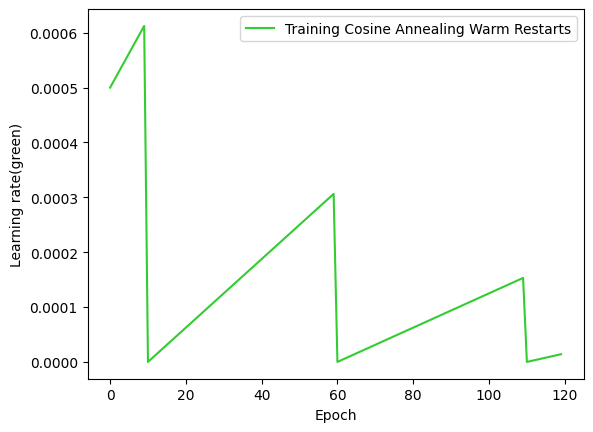

In [25]:
# lrs = []
# for i in range(68):
#     optimizer.step()
#     lrs.append(optimizer.param_groups[0]["lr"])
#     scheduler.step()


# plt.plot(range(120), lrs, color = 'limegreen',  label = 'Training Cosine Annealing Warm Restarts')
# plt.xlabel('Epoch')
# plt.ylabel('Learning rate(green)')
# plt.legend()
# plt.show()

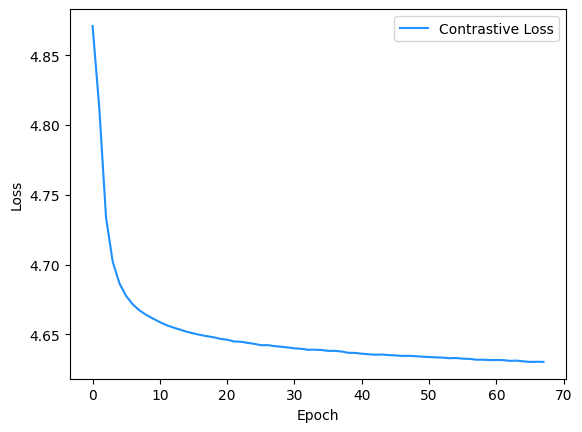

In [10]:
import matplotlib.pyplot as plt

plt.plot(range(68),train_loss_history, color = 'dodgerblue', label = 'Contrastive Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [11]:
torch.save({"model_state_dict": model.state_dict(),
            },
           f"Contrastive_Embedding_Net(0122encoder).pt")

In [12]:
print(model)

Contrastive_Embedding(
  (encoder): Sequential(
    (0): Linear(in_features=217, out_features=107, bias=True)
    (1): BatchNorm1d(107, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.6344408574936754, inplace=False)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=107, out_features=96, bias=True)
    (5): BatchNorm1d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.6344408574936754, inplace=False)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=96, out_features=67, bias=True)
    (9): BatchNorm1d(67, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout(p=0.6344408574936754, inplace=False)
    (11): LeakyReLU(negative_slope=0.01)
  )
)


In [6]:
device            = torch.device('cuda:0')

In [9]:
hidden, SEED, batch_size, lr, total_epoch, drop_rate, temp = param()

In [12]:
model = Contrastive_Embedding(217, drop_rate, hidden['hidden']).to(device)

In [13]:
checkpoint = torch.load("Contrastive_Embedding_Net(0122encoder).pt")
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [14]:
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
import time
import gc

gc.collect()

loader_val_out = DataLoader(dataset_val, batch_size=64, shuffle=False, drop_last=False)

import torch
from tqdm import tqdm
import numpy as np
import pandas as pd
import gc
import time

def make_embeded_df_valid(model_name):
    print('Start Getting the latent space vector (Valid sample)')
    start = time.time()

    model_name.eval()
    with torch.no_grad():
        emb_valid_list = []
        label_valid_list = []

        for num_iter, batch_data in enumerate(tqdm(loader_val_out)):
            X_num, X_cat, label = batch_data
            X_num, X_cat = X_num.to(device), X_cat.to(device)
            latent = model_name(X_cat, X_num)

            # Latent 데이터와 레이블 저장
            emb_valid_list.append(latent.cpu().numpy())
            label_valid_list.append(label.numpy())


            gc.collect()

        # 리스트를 하나의 넘파이 배열로 변환
        emb_valid_array = np.concatenate(emb_valid_list, axis=0)
        label_valid_array = np.concatenate(label_valid_list, axis=0)

    # DataFrame 생성
    emb_valid = pd.DataFrame(emb_valid_array)
    emb_valid_label = pd.DataFrame(label_valid_array)
    emb_valid_full = pd.concat([emb_valid, emb_valid_label], axis=1)
    end = time.time()            
    print('End, Time consume (min): {}'.format((end - start)/60))  
    
    return emb_valid_full

# 모델 실행
emb_valid = make_embeded_df_valid(model)

Start Getting the latent space vector (Valid sample)


100%|██████████| 4196/4196 [03:51<00:00, 18.13it/s]

End, Time consume (min): 3.85855846007665


In [16]:
emb_valid.to_csv('test_umap_encoder.csv')